In [123]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import re
import nltk
import os
nltk.download('stopwords')
nltk.download('punkt')
import ktrain
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from ktrain import text
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import hashing_trick
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import optuna
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asadn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asadn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def preprocess_data(data):
    
    pdata = []
    stopwords = nltk.corpus.stopwords.words("english")
    
    for i in data:
        i = i.replace('\s+',' ')
        i = i.replace('[-?:.!]', '')
        i = i.strip()
        i = i.lower()
        i = i.split()
        pdata.append(i)
    
    corpus =  list(map(lambda x: [item for item in x if item not in stopwords], pdata))
    pdata = []

    for s in corpus:
        pdata.append(s)

    for i in range(len(pdata)):
        pdata[i]=' '.join(pdata[i])
        
    return pdata

In [220]:
def plot_class_distribution(Y):

    counts = np.unique(Y, return_counts=True)

    plt.figure(figsize=(10,5))
    plt.bar(counts[0], counts[1], color = 'g')
    plt.xlabel('Class')
    plt.xticks(counts[0])
    plt.ylabel('Number of Samples')
    plt.title('Distribution of classes')
    plt.show()

In [4]:
def read_data(path):
    
    data = pd.read_csv(path)
    
    return data

In [5]:
def encode_labels(data):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(data)
    y_train = label_encoder.transform(data)
    
    return y_train, label_encoder

In [68]:
def hash_encoding(X):
    vocab_size=1000
    hash_encoded = [hashing_trick(text=word, n=vocab_size, hash_function='md5') for word in X]
    max_tokens = -1
    for oh in hash_encoded:
        if len(oh) > max_tokens:
            max_tokens = len(oh)
    padded_hash_encoded =pad_sequences(hash_encoded ,padding='pre',maxlen=max_tokens)
    return padded_onehot_encoded, max_tokens

In [93]:
def build_ann_model(input_size, learning_rate=0.01):
    
    model=Sequential()
    model.add(Dense(units=512, activation='relu', input_shape=(input_size,)))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=27, activation='softmax'))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model
    

In [128]:
def build_cnn_model(input_size, learning_rate=0.01):
    
    model=Sequential()
    model.add(Conv1D(512, 3, activation='relu', padding='same', input_shape=(input_size, 1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(27, activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model
    

In [49]:
def build_lstm_model(max_tokens, embed_features=30, LSTM_units=100, learning_rate=0.01):
    
    vocab_size=1000
    model=Sequential()
    model.add(Embedding(vocab_size,embed_features,input_length=max_tokens))
    model.add(LSTM(units=LSTM_units))
    model.add(Dense(units=27, activation='softmax'))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

In [50]:
def build_bilstm_model(max_tokens, embed_features=30, LSTM_units=100, learning_rate=0.01):
    
    vocab_size=1000
    model=Sequential()
    model.add(Embedding(vocab_size,embed_features,input_length=max_tokens))
    model.add(Bidirectional(LSTM(units=LSTM_units)))
    model.add(Dense(units=27, activation='softmax'))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

In [51]:
def plot_training_curve(history):
    
    plt.figure(figsize=(12, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='r')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Per Epoch')
    plt.legend()
    plt.grid(False)

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='r')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies Per Epoch')
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()

In [193]:
def plot_compound_training_curves(histories, model_names):
 
    if len(histories) != len(model_names):
        raise ValueError("Length of histories and model_names must be the same")

    fig, axs = plt.subplots(1, 2, figsize=(18, 6)) # Changed to 1 row, 2 columns

    # Plotting loss for all models
    for history, name in zip(histories, model_names):
        axs[0].plot(history.history['loss'], label=f'{name} Training Loss', linestyle='--')
        axs[0].plot(history.history['val_loss'], label=f'{name} Validation Loss')

    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(False)

    # Plotting accuracy for all models
    for history, name in zip(histories, model_names):
        axs[1].plot(history.history['accuracy'], label=f'{name} Training Accuracy', linestyle='--')
        axs[1].plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')

    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(False)

    plt.tight_layout()
    plt.show()

In [52]:
def plot_accuracy(accuracy, precision, recall, f1):
    plt.bar(['Accuracy', 'Precision', 'Recall', 'F1-Score'], [accuracy, precision, recall, f1], color='g')
    plt.xlabel('Measure')
    plt.ylabel('Score')
    plt.title('Model Evaluation Metrics')
    plt.show()

In [181]:
def plot_compound_bar_chart(labels, scores):

    # Assuming the order in each list is [accuracy, recall, precision, f1 score]
    labels = labels
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    # Transposing the list of lists to segregate each metric
    transposed_scores = list(map(list, zip(*scores)))

    # Setting up the bar chart
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    for i, metric_scores in enumerate(transposed_scores):
        ax.bar(x + i*width, metric_scores, width, label=metrics[i])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Scores by Model and Metric')
    ax.set_xticks(x + width + width/2)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

In [132]:
def evaluate(model, x_test, y_test):
    
    preds = model.predict(x_test)
    pred_classes = np.argmax(preds, axis=1)

    precision = precision_score(y_test, pred_classes, average='macro', zero_division=0)
    recall = recall_score(y_test, pred_classes, average='macro', zero_division=0)
    f1 = f1_score(y_test, pred_classes, average='macro', zero_division=0)
    accuracy = accuracy_score(y_test, pred_classes)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')
    
    plot_accuracy(accuracy, precision, recall, f1)
    return pred_classes, [accuracy, precision, recall, f1]

In [54]:
def displayConfusionMatrix(model, x_test, y_test):
    
    preds = model.predict(x_test)
    pred_classes = np.argmax(preds, axis=1)
    fig, ax = plt.subplots(figsize=(10,10))
    ConfusionMatrixDisplay.from_predictions(y_test, pred_classes, cmap='YlGn', ax=ax)


In [195]:
# Function to Set Objective and Structure for Hyperparameter Tuning
def tune_objective(trial):
    
    # Hyperparameters to be optimized
    epochs = trial.suggest_int('epochs', 5, 10, 15)
    lstm_units = trial.suggest_int('lstm_units', 30, 50, 100)
    batch_size = trial.suggest_int('batch_size', 256, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    max_tokens = 10
    
    # Create model with current hyperparameters
    model = build_bilstm_model(max_tokens=max_tokens,
                    embed_features=30,
                    learning_rate=learning_rate,
                    LSTM_units=lstm_units)
        
    # Train model
    history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Return the validation loss
    return history.history['val_accuracy'][-1]

In [56]:
# Function for Hyperparmeter Tuning
def tune_model():
    study = optuna.create_study(direction='maximize')
    study.optimize(tune_objective, n_trials=20)
    return study

In [57]:
def predict(model, query):
    
    vocab_size=1000
    max_tokens = 10
    
    preprocessed_query = preprocess_data([query])
    preprocessed_query = np.array(preprocessed_query)
    hash_encoded = [hashing_trick(text=word, n=vocab_size, hash_function='md5') for word in preprocessed_query]
    padded_hash_encoded =pad_sequences(hash_encoded ,padding='pre',maxlen=max_tokens)
    result = model.predict(padded_hash_encoded)
    result_class = np.argmax(result, axis=1)
    
    return result_class

In [137]:
data = read_data('../Dataset/Bitext_Sample_Customer_Support_Training_Dataset.csv')

In [138]:
data

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...
...,...,...,...,...,...
26867,BL,I am waiting for a rebate of {{Refund Amount}}...,REFUND,track_refund,Thank you for sharing your situation regarding...
26868,BIL,how to see if there is anything wrong with my ...,REFUND,track_refund,Ensuring the accuracy of your restitution is o...
26869,BLQZ,I'm waiting for a reimbjrsement of {{Currency ...,REFUND,track_refund,"Firstly, I genuinely understand the importance..."
26870,BL,I don't know what to do to see my reimbursemen...,REFUND,track_refund,I've understood you're unsure about how to che...


In [139]:
X = data['instruction']
Y = data['intent']

In [140]:
X

0         question about cancelling order {{Order Number}}
1        i have a question about cancelling oorder {{Or...
2          i need help cancelling puchase {{Order Number}}
3               I need to cancel purchase {{Order Number}}
4        I cannot afford this order, cancel purchase {{...
                               ...                        
26867    I am waiting for a rebate of {{Refund Amount}}...
26868    how to see if there is anything wrong with my ...
26869    I'm waiting for a reimbjrsement of {{Currency ...
26870    I don't know what to do to see my reimbursemen...
26871    I need to know if there is anything new on the...
Name: instruction, Length: 26872, dtype: object

In [141]:
Y, label_encoder = encode_labels(Y)

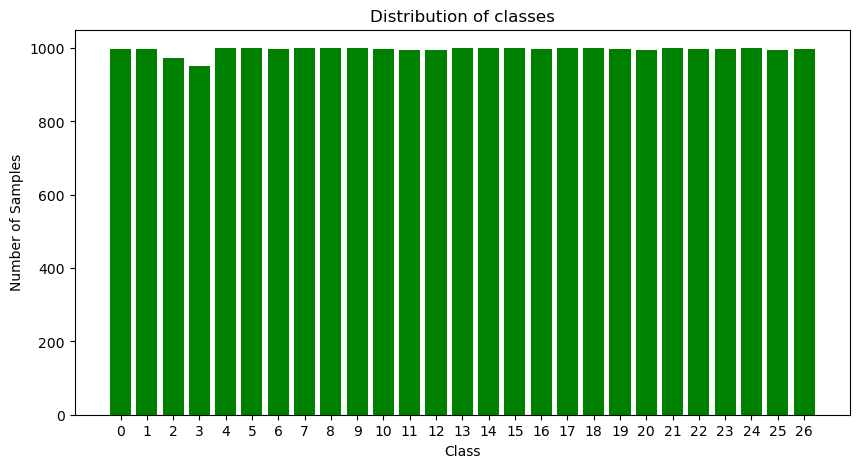

In [221]:
plot_class_distribution(Y)

In [143]:
X = preprocess_data(X)  

In [144]:
X

['question cancelling order {{order number}}',
 'question cancelling oorder {{order number}}',
 'need help cancelling puchase {{order number}}',
 'need cancel purchase {{order number}}',
 'cannot afford order, cancel purchase {{order number}}',
 'help cancel order {{order number}}?',
 'longer afford order {{order number}}, cancel',
 'trying cancel purchase {{order number}}',
 'got cancel purchase {{order number}}',
 'need help canceling purchase {{order number}}',
 'dont know cancel order {{order number}}',
 'problem cancelling purchase {{order number}}',
 'problem canceling purchase {{order number}}',
 'help canceling order {{order number}}?',
 'help canceling purchase {{order number}}',
 'help cancel purchase {{order number}}?',
 'cancel purchase {{order number}}?',
 'bought item twice, cancel order {{order number}}',
 'need help canceling order {{order number}}',
 'want assistance canceling order {{order number}}',
 "i'm trying cancel order {{order number}}",
 'problems canceling or

In [145]:
X = np.array(X)
Y = np.array(Y)

In [146]:
padded_hash_encoded, max_tokens = hash_encoding(X)

In [147]:
padded_hash_encoded

array([[  0,   0,   0, ..., 598, 598, 729],
       [  0,   0,   0, ..., 444, 598, 729],
       [  0,   0,   0, ..., 408, 598, 729],
       ...,
       [  0,   0,   0, ..., 274, 933, 413],
       [  0,   0,   0, ..., 683, 385, 182],
       [  0,   0,   0, ...,  31, 718, 753]])

In [148]:
print('The longest sentence in our training data contains exactly',max_tokens,'tokens')

The longest sentence in our training data contains exactly 10 tokens


In [149]:
x_train, x_val, y_train, y_val = train_test_split(padded_hash_encoded, Y, test_size=0.2, random_state=42)

In [150]:
len(x_train)

21497

In [151]:
len(x_val)

5375

In [152]:
ann_model = build_ann_model(input_size=max_tokens,
                            learning_rate=0.001)

In [153]:
ann_history = ann_model.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=10,batch_size=1024)

Epoch 1/10
21/21 [==============================] - 2s 32ms/step - loss: 30.9641 - accuracy: 0.0567 - val_loss: 7.3317 - val_accuracy: 0.0813
Epoch 2/10
21/21 [==============================] - 0s 22ms/step - loss: 4.4280 - accuracy: 0.0763 - val_loss: 3.2630 - val_accuracy: 0.0610
Epoch 3/10
21/21 [==============================] - 0s 21ms/step - loss: 3.2388 - accuracy: 0.0544 - val_loss: 3.2199 - val_accuracy: 0.0558
Epoch 4/10
21/21 [==============================] - 0s 21ms/step - loss: 3.1944 - accuracy: 0.0641 - val_loss: 3.1884 - val_accuracy: 0.0683
Epoch 5/10
21/21 [==============================] - 0s 21ms/step - loss: 3.1599 - accuracy: 0.0868 - val_loss: 3.1550 - val_accuracy: 0.0858
Epoch 6/10
21/21 [==============================] - 0s 22ms/step - loss: 3.1284 - accuracy: 0.1015 - val_loss: 3.1270 - val_accuracy: 0.1025
Epoch 7/10
21/21 [==============================] - 0s 21ms/step - loss: 3.0922 - accuracy: 0.1091 - val_loss: 3.0820 - val_accuracy: 0.1103
Epoch 8/10
2

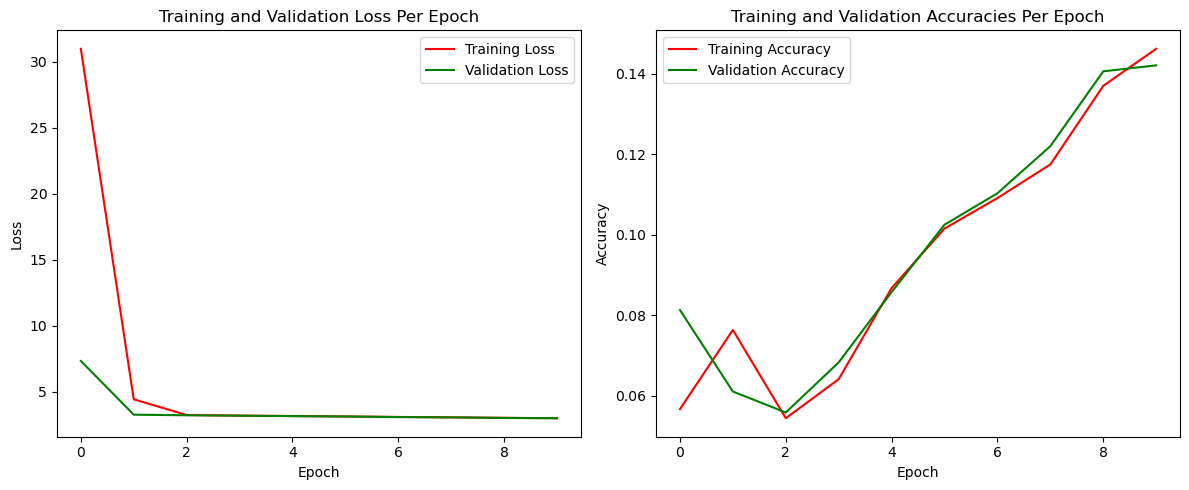

In [174]:
plot_training_curve(ann_history)

168/168 [==============================] - 0s 2ms/step
Accuracy: 0.14
Precision: 0.15
Recall: 0.14
F1-score: 0.12


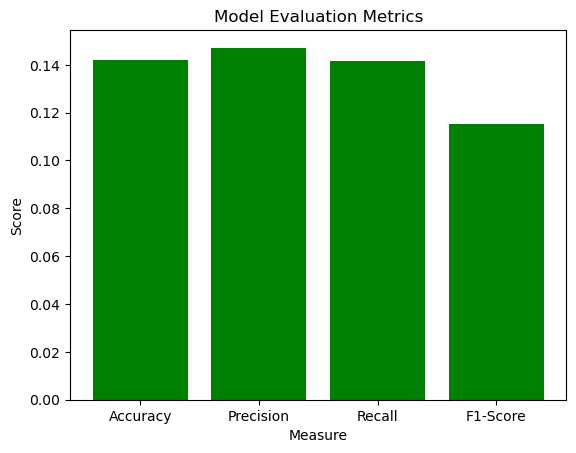

In [154]:
ann_classes, ann_accuracy = evaluate(ann_model, x_val, y_val)

In [155]:
cnn_model = build_cnn_model(input_size=max_tokens,
                            learning_rate=0.001)

In [156]:
cnn_history = cnn_model.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=10,batch_size=1024)

Epoch 1/10
21/21 [==============================] - 8s 295ms/step - loss: 9.6854 - accuracy: 0.0446 - val_loss: 3.2661 - val_accuracy: 0.0644
Epoch 2/10
21/21 [==============================] - 6s 301ms/step - loss: 3.2864 - accuracy: 0.0443 - val_loss: 3.2635 - val_accuracy: 0.0595
Epoch 3/10
21/21 [==============================] - 6s 283ms/step - loss: 3.2659 - accuracy: 0.0596 - val_loss: 3.2244 - val_accuracy: 0.0982
Epoch 4/10
21/21 [==============================] - 6s 286ms/step - loss: 3.2442 - accuracy: 0.0693 - val_loss: 3.1739 - val_accuracy: 0.1040
Epoch 5/10
21/21 [==============================] - 6s 279ms/step - loss: 3.2083 - accuracy: 0.0802 - val_loss: 3.1405 - val_accuracy: 0.1260
Epoch 6/10
21/21 [==============================] - 6s 289ms/step - loss: 3.1689 - accuracy: 0.0886 - val_loss: 3.0953 - val_accuracy: 0.1416
Epoch 7/10
21/21 [==============================] - 6s 277ms/step - loss: 3.1383 - accuracy: 0.0952 - val_loss: 3.0390 - val_accuracy: 0.1423
Epoch 

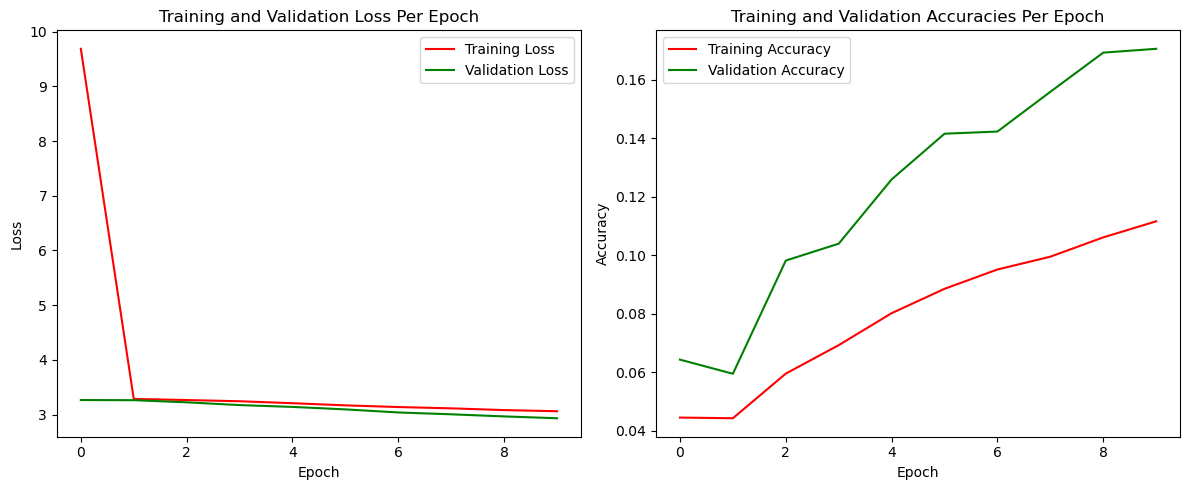

In [173]:
plot_training_curve(cnn_history)

168/168 [==============================] - 1s 4ms/step
Accuracy: 0.17
Precision: 0.14
Recall: 0.17
F1-score: 0.12


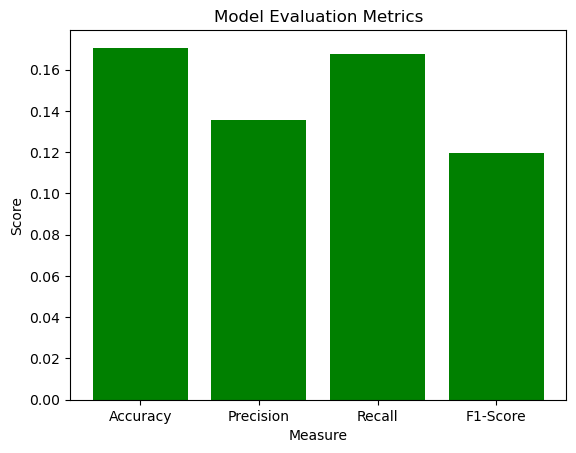

In [157]:
cnn_classes, cnn_accuracy = evaluate(cnn_model, x_val, y_val)

In [165]:
lstm_model = build_lstm_model(max_tokens=max_tokens,
                    embed_features=30,
                    learning_rate=0.001,
                    LSTM_units=50)

In [166]:
lstm_history = lstm_model.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=5,batch_size=1024)

Epoch 1/5
21/21 [==============================] - 5s 85ms/step - loss: 3.2812 - accuracy: 0.1745 - val_loss: 3.2601 - val_accuracy: 0.3790
Epoch 2/5
21/21 [==============================] - 1s 49ms/step - loss: 3.2165 - accuracy: 0.4352 - val_loss: 3.1439 - val_accuracy: 0.3498
Epoch 3/5
21/21 [==============================] - 1s 48ms/step - loss: 2.9630 - accuracy: 0.3053 - val_loss: 2.6648 - val_accuracy: 0.3700
Epoch 4/5
21/21 [==============================] - 1s 48ms/step - loss: 2.2543 - accuracy: 0.4803 - val_loss: 1.8775 - val_accuracy: 0.6104
Epoch 5/5
21/21 [==============================] - 1s 47ms/step - loss: 1.5626 - accuracy: 0.6759 - val_loss: 1.3135 - val_accuracy: 0.7349


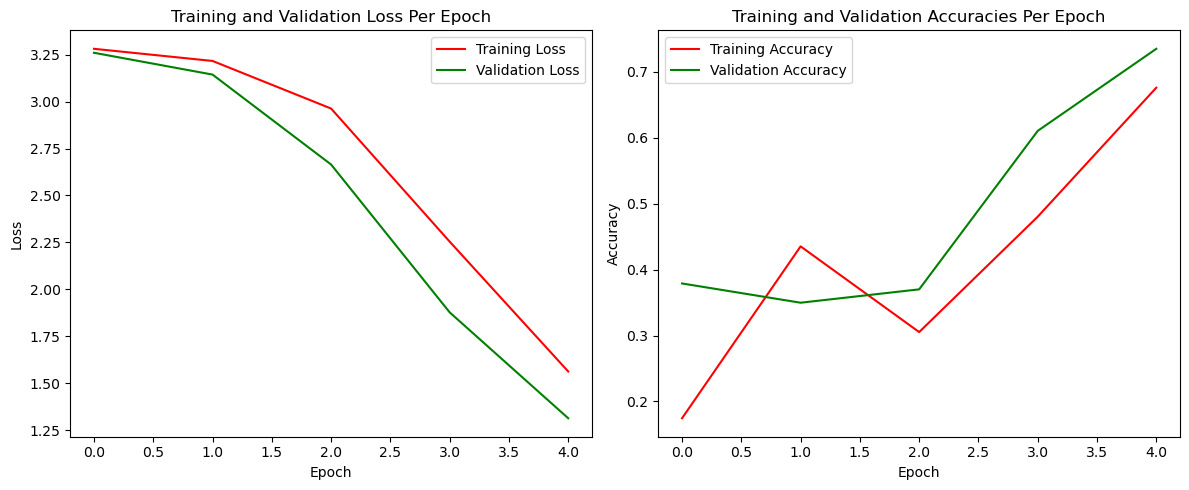

In [172]:
plot_training_curve(lstm_history)

168/168 [==============================] - 0s 3ms/step
Accuracy: 0.73
Precision: 0.78
Recall: 0.73
F1-score: 0.71


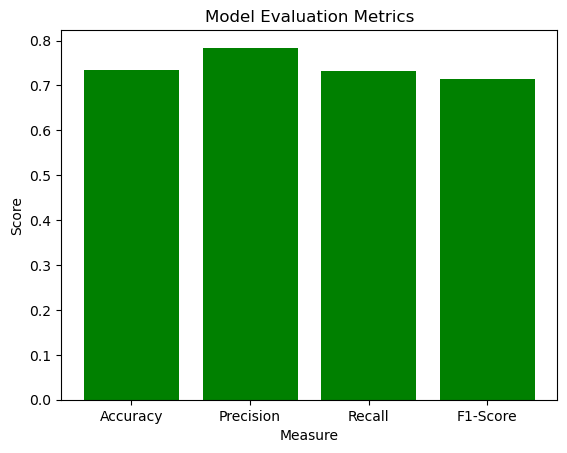

In [168]:
lstm_classes, lstm_accuracy = evaluate(lstm_model, x_val, y_val)

In [169]:
bilstm_model = build_bilstm_model(max_tokens=max_tokens,
                    embed_features=30,
                    learning_rate=0.001,
                    LSTM_units=40)

In [170]:
bilstm_history = bilstm_model.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=5,batch_size=512)

Epoch 1/5
42/42 [==============================] - 8s 66ms/step - loss: 3.2539 - accuracy: 0.1424 - val_loss: 3.1467 - val_accuracy: 0.2050
Epoch 2/5
42/42 [==============================] - 1s 36ms/step - loss: 2.5741 - accuracy: 0.2891 - val_loss: 1.8748 - val_accuracy: 0.5585
Epoch 3/5
42/42 [==============================] - 1s 35ms/step - loss: 1.2961 - accuracy: 0.6959 - val_loss: 0.8200 - val_accuracy: 0.8333
Epoch 4/5
42/42 [==============================] - 1s 34ms/step - loss: 0.6270 - accuracy: 0.8684 - val_loss: 0.4682 - val_accuracy: 0.9252
Epoch 5/5
42/42 [==============================] - 1s 33ms/step - loss: 0.3764 - accuracy: 0.9385 - val_loss: 0.3045 - val_accuracy: 0.9533


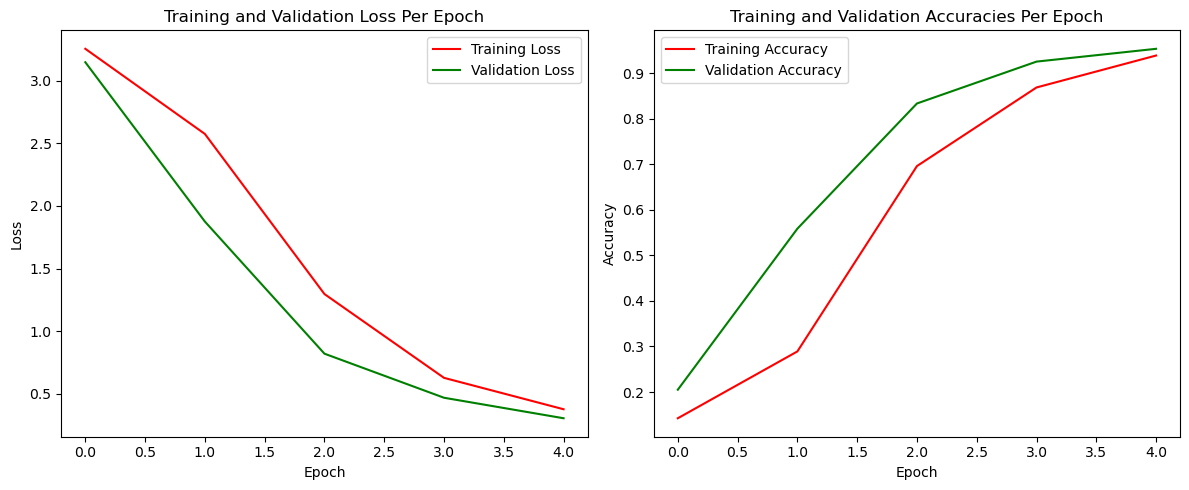

In [171]:
plot_training_curve(bilstm_history)

168/168 [==============================] - 1s 3ms/step
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-score: 0.95


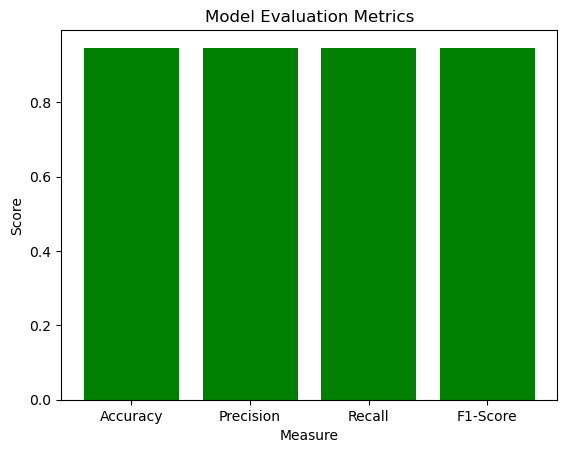

In [175]:
bilstm_classes, bilstm_accuracy = evaluate(model, x_val, y_val)

168/168 [==============================] - 2s 3ms/step


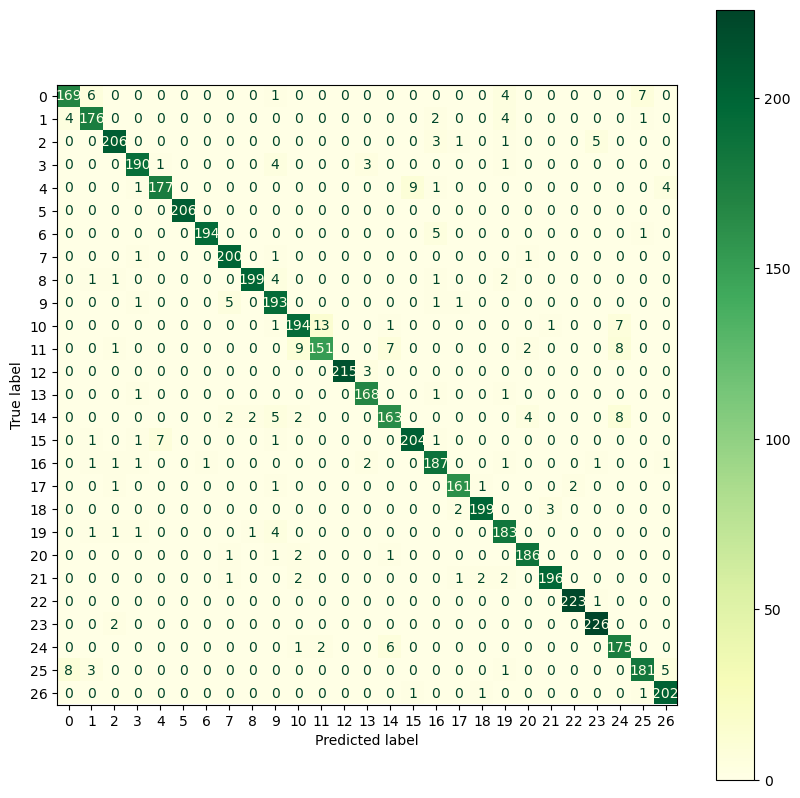

In [176]:
displayConfusionMatrix(bilstm_model, x_val, y_val)

In [178]:
targets = np.unique(np.array(data['intent'])).tolist()
report = classification_report(y_val,bilstm_classes,target_names=targets)
print(report)

                          precision    recall  f1-score   support

            cancel_order       0.97      0.91      0.94       187
            change_order       0.94      0.93      0.93       187
 change_shipping_address       0.93      0.86      0.90       216
  check_cancellation_fee       0.93      0.93      0.93       199
           check_invoice       0.94      0.94      0.94       192
   check_payment_methods       0.99      0.99      0.99       206
     check_refund_policy       0.97      0.96      0.97       200
               complaint       0.97      0.97      0.97       203
contact_customer_service       0.96      0.98      0.97       208
     contact_human_agent       0.91      0.98      0.94       201
          create_account       0.97      0.90      0.93       217
          delete_account       0.87      0.96      0.91       178
        delivery_options       0.93      0.98      0.96       218
         delivery_period       0.98      0.98      0.98       171
         

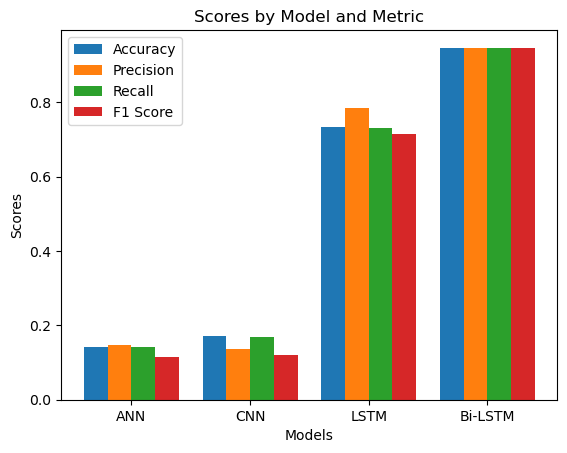

In [182]:
plot_compound_bar_chart(['ANN','CNN','LSTM','Bi-LSTM'],[ann_accuracy, cnn_accuracy, lstm_accuracy, bilstm_accuracy])

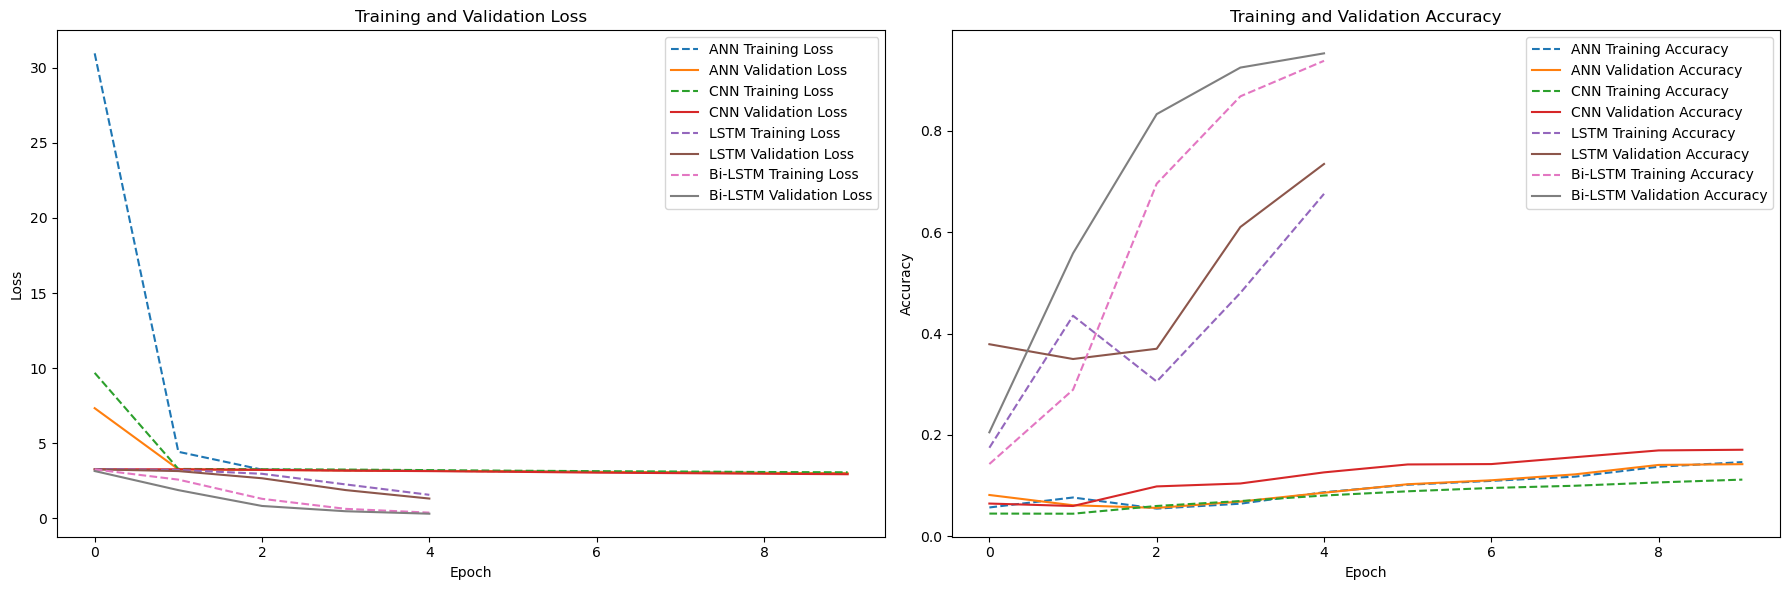

In [194]:
plot_compound_training_curves([ann_history, cnn_history, lstm_history, bilstm_history],['ANN','CNN','LSTM','Bi-LSTM'])

In [196]:
#Hyperparameter Tuning
study = tune_model()
print("Best parameters:", study.best_params)
print("Best validation Accuracy:", study.best_value)

[I 2023-12-02 18:23:10,090] A new study created in memory with name: no-name-c9dd9a55-ad01-45c7-8438-124fe0d4ce38
C:\Users\asadn\anaconda3\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [5, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
C:\Users\asadn\anaconda3\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [30, 50] and step=100, but the range is not divisible by `step`. It will be replaced by [30, 30].
  warnings.warn(
[I 2023-12-02 18:23:25,485] Trial 0 finished with value: 0.9572092890739441 and parameters: {'epochs': 5, 'lstm_units': 30, 'batch_size': 336, 'learning_rate': 0.0010657166451968913}. Best is trial 0 with value: 0.9572092890739441.
[I 2023-12-02 18:23:39,472] Trial 1 finished with value: 0.9748837351799011 and parameters: {'epochs': 5, 'lstm_units': 30, 'batch_size': 264, 'learning_rate': 0.002138026104745871}. Best is t

Best parameters: {'epochs': 5, 'lstm_units': 30, 'batch_size': 512, 'learning_rate': 0.009290632908084191}
Best validation Accuracy: 0.9832558035850525


In [197]:
tuned_model = build_bilstm_model(max_tokens=max_tokens,
                    embed_features=30,
                    learning_rate=study.best_params['learning_rate'],
                    LSTM_units=study.best_params['lstm_units'])

In [198]:
tuned_history = tuned_model.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=study.best_params['epochs'],batch_size=study.best_params['batch_size'])

Epoch 1/5
42/42 [==============================] - 8s 58ms/step - loss: 1.6250 - accuracy: 0.6126 - val_loss: 0.2561 - val_accuracy: 0.9436
Epoch 2/5
42/42 [==============================] - 1s 28ms/step - loss: 0.1376 - accuracy: 0.9659 - val_loss: 0.1094 - val_accuracy: 0.9713
Epoch 3/5
42/42 [==============================] - 1s 34ms/step - loss: 0.0634 - accuracy: 0.9841 - val_loss: 0.0835 - val_accuracy: 0.9782
Epoch 4/5
42/42 [==============================] - 1s 29ms/step - loss: 0.0428 - accuracy: 0.9887 - val_loss: 0.0790 - val_accuracy: 0.9792
Epoch 5/5
42/42 [==============================] - 1s 30ms/step - loss: 0.0307 - accuracy: 0.9927 - val_loss: 0.0751 - val_accuracy: 0.9799


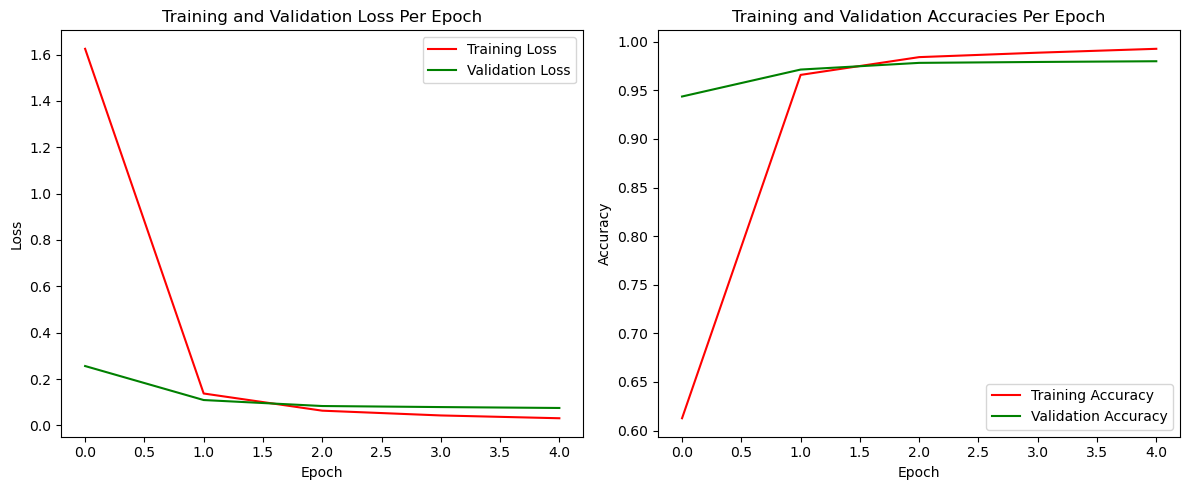

In [200]:
plot_training_curve(tuned_history)

168/168 [==============================] - 0s 3ms/step
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1-score: 0.98


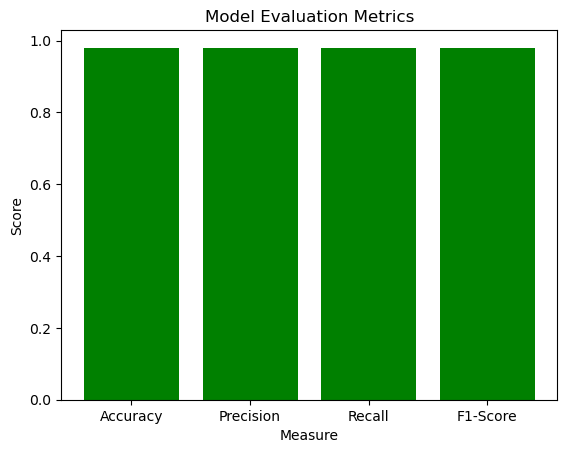

In [204]:
tuned_classes, tuned_accuracied = evaluate(tuned_model, x_val, y_val)

168/168 [==============================] - 0s 3ms/step


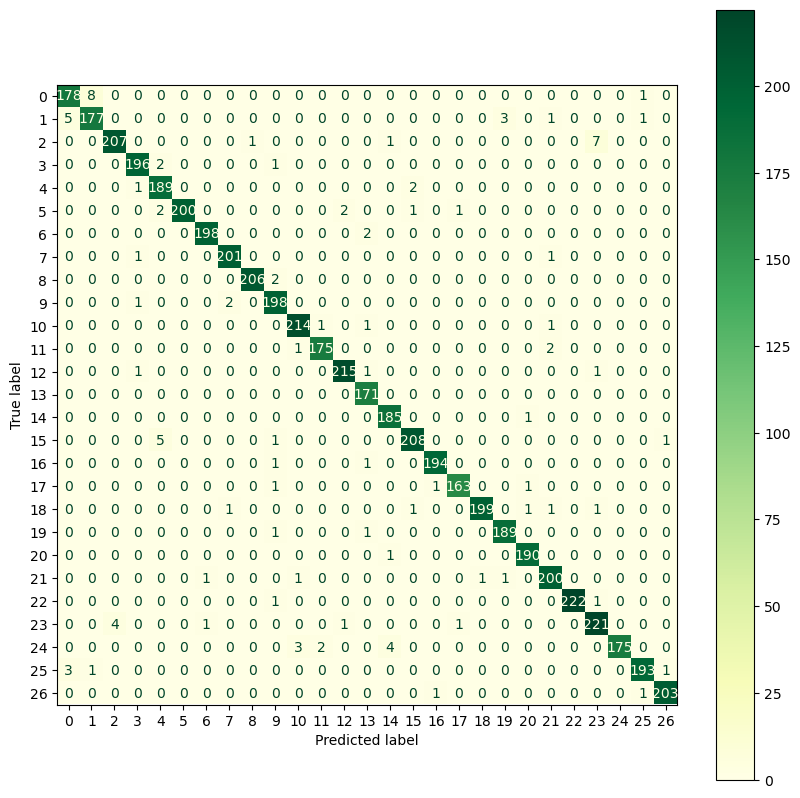

In [205]:
displayConfusionMatrix(tuned_model, x_val, y_val)

In [206]:
targets = np.unique(np.array(data['intent'])).tolist()
report = classification_report(y_val,tuned_classes,target_names=targets)
print(report)

                          precision    recall  f1-score   support

            cancel_order       0.96      0.95      0.95       187
            change_order       0.95      0.95      0.95       187
 change_shipping_address       0.98      0.96      0.97       216
  check_cancellation_fee       0.98      0.98      0.98       199
           check_invoice       0.95      0.98      0.97       192
   check_payment_methods       1.00      0.97      0.99       206
     check_refund_policy       0.99      0.99      0.99       200
               complaint       0.99      0.99      0.99       203
contact_customer_service       1.00      0.99      0.99       208
     contact_human_agent       0.96      0.99      0.97       201
          create_account       0.98      0.99      0.98       217
          delete_account       0.98      0.98      0.98       178
        delivery_options       0.99      0.99      0.99       218
         delivery_period       0.97      1.00      0.98       171
         

In [207]:
model_with_callback = build_bilstm_model(max_tokens=max_tokens,
                        embed_features=30,
                        learning_rate=study.best_params['learning_rate'],
                        LSTM_units=study.best_params['lstm_units'])

In [208]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

In [209]:
chistory = model_with_callback.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=10,batch_size=study.best_params['batch_size'], callbacks=[callback])

Epoch 1/10
42/42 [==============================] - 9s 70ms/step - loss: 1.5983 - accuracy: 0.5895 - val_loss: 0.2526 - val_accuracy: 0.9468
Epoch 2/10
42/42 [==============================] - 1s 26ms/step - loss: 0.1351 - accuracy: 0.9695 - val_loss: 0.1020 - val_accuracy: 0.9753
Epoch 3/10
42/42 [==============================] - 1s 26ms/step - loss: 0.0603 - accuracy: 0.9857 - val_loss: 0.0819 - val_accuracy: 0.9782
Epoch 4/10
42/42 [==============================] - 1s 26ms/step - loss: 0.0429 - accuracy: 0.9894 - val_loss: 0.0686 - val_accuracy: 0.9807
Epoch 5/10
42/42 [==============================] - 1s 26ms/step - loss: 0.0325 - accuracy: 0.9919 - val_loss: 0.0630 - val_accuracy: 0.9823
Epoch 6/10
42/42 [==============================] - 1s 26ms/step - loss: 0.0232 - accuracy: 0.9942 - val_loss: 0.0653 - val_accuracy: 0.9834
Epoch 7/10
42/42 [==============================] - 1s 26ms/step - loss: 0.0206 - accuracy: 0.9948 - val_loss: 0.0613 - val_accuracy: 0.9853
Epoch 8/10
42

168/168 [==============================] - 0s 3ms/step
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1-score: 0.98


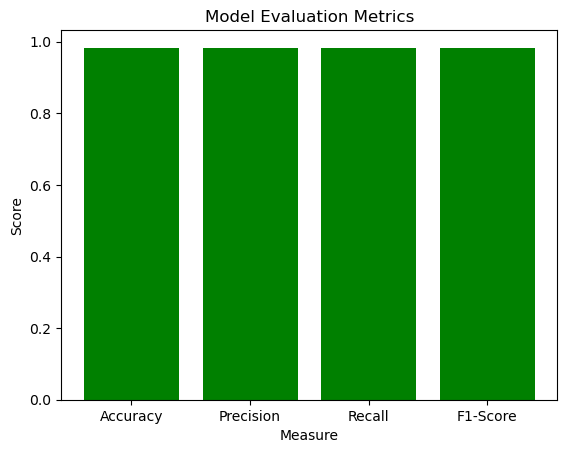

In [211]:
callback_classes, callback_accuracy = evaluate(model_with_callback, x_val, y_val)

In [215]:
answer = predict(model_with_callback, 'I want to change my account')

1/1 [==============================] - 0s 24ms/step


In [216]:
labels = label_encoder.inverse_transform(answer)

In [217]:
print(f'The sentence refers to "{labels[0]}"')

The sentence refers to "switch_account"


In [218]:
tuned_model.save('./Models/intent_model.h5')
tuned_model.save('./Models/intent_model.keras')

C:\Users\asadn\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [219]:
joblib.dump(label_encoder,'./Encoder/label_encoder.joblib')

['./Encoder/label_encoder.joblib']